# Experiments

## Dataset 1 - Breast Cancer

In [51]:
from sklearn.datasets import load_breast_cancer
X, Y = load_breast_cancer(return_X_y=True)

## Preparing data

In [52]:
from sklearn.preprocessing import OneHotEncoder
from collinearity import SelectNonCollinear
from sklearn.preprocessing import StandardScaler
import numpy as np

def remove_missing_rows(X, Y):
    mask = np.isnan(X).sum(axis=1) == 0
    return X[mask], Y[mask]

def encode_categorical(X):
    mask = np.array([isinstance(x, str) for x in X[0]])
    if mask.sum() > 0:    
        X = X[:, mask]
        enc = OneHotEncoder(handle_unknown='ignore')
        enc.fit(X)
        X = enc.transform(X).toarray()
    return X

def remove_colinear(X, correlation_threshold=0.9):
    # Source: https://github.com/gianlucamalato/collinearity
    # 1. Take the couple of features that have the lowest absolute 
    #    value of the linear correlation coefficient.
    # 2. If it's lower than the threshold, consider these features
    # 3. Keep adding features as long as the correlation matrix doesn't
    #    show off-diagonal elements whose absolute value is greater than the threshold.
    selector = SelectNonCollinear(correlation_threshold=correlation_threshold)
    selector.fit(X, y=None)
    X = selector.transform(X)
    columns_selection = selector.get_support()
    return X, columns_selection   

def scale_features(X):
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    return X

Before preparation:

In [53]:
print(f"In the raw data, there are {X.shape[0]} observations and {X.shape[1]} features.")

In the raw data, there are 569 observations and 30 features.


Dropping rows with missing values, encoding categorical variables, dropping features with correlation > 0.9, and scaling the data.

In [54]:
X, Y = remove_missing_rows(X, Y)
X = encode_categorical(X)
X, columns_selection = remove_colinear(X, correlation_threshold=0.9)

After preparation:

In [55]:
print(f"In the prepared data, there are {X.shape[0]} observations and {X.shape[1]} features (removed {len(columns_selection) - np.array(columns_selection).sum()} features).")

In the prepared data, there are 569 observations and 21 features (removed 9 features).


### Train/Test Split

In [56]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Models and metrics

In [57]:
import pandas as pd

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from LogisticRegressionIRLS import LR
from sklearn.neighbors import KNeighborsClassifier
from functools import partial

class LRWrapper(LR):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def fit(self, X, Y):
        X = pd.DataFrame(X)
        Y = Y.reshape(-1, 1)
        super().fit(X, Y)
        return self
    
    def predict(self, X):
        X = pd.DataFrame(X)
        Y = super().predict(X)
        return Y

models = {'LDA': LinearDiscriminantAnalysis,
        'QDA': QuadraticDiscriminantAnalysis,
        'Logistic Regression': LogisticRegression,
        'Logistic Regression IRLS': partial(LRWrapper, maximisation_minorisation=True),
        'KNN': KNeighborsClassifier}

In [58]:
from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

def metric_bootstrap(X, Y, model_class, n=10):
    model = model_class()
    error = 0
    lenght_of_y = 0
    for i in range(n):
        sample_ids = resample(range(len(X)), replace=True, n_samples=len(X))

        test_ids = [i for i in range(len(X)) if i not in sample_ids]
        if len(sample_ids) == len(test_ids):
            i -= 1
            continue
        lenght_of_y += len(test_ids)
        train_ids = [i for i in range(len(X)) if i in sample_ids]
        model.fit(X[train_ids], Y[train_ids])
        y_pred = model.predict(X[test_ids])
        for i in range(len(y_pred)):
            if Y[test_ids[i]] != y_pred[i]:
                error += 1
    error_bootstrap = error / lenght_of_y
    accuracy_bootstrap = 1 - error_bootstrap
    return accuracy_bootstrap

metrics = {'precision': partial(precision_score, zero_division=0),
            'recall': recall_score,
            'accuracy': accuracy_score,
            'f1': f1_score,
            'bootstrap': metric_bootstrap}

## Experiments

Test run.

In [59]:
import pandas as pd
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter(action='ignore', category=ConvergenceWarning)

def train_model(model_class, X_train, X_test, Y_train, Y_test, metrics, model_name='model'):
    X = np.concatenate((X_train, X_test))
    Y = np.concatenate((Y_train, Y_test))
    model = model_class()
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    return {'model':model_name} |\
            {metric: metrics[metric](Y_test, Y_pred) for metric in metrics if metric != 'bootstrap'} |\
            {f'bootstrap accuracy': metrics['bootstrap'](X, Y, model_class)}

def train_models(models, X, Y, metrics, test_size):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)
    results = []
    for model_name, model_class in models.items():
        results.append(train_model(model_class, X_train, X_test, Y_train, Y_test, metrics, model_name=model_name))
    df = pd.DataFrame(results)
    return df

df = train_models(models, X, Y, metrics, test_size=0.2)
df

,model,precision,recall,accuracy,f1,bootstrap accuracy
0,LDA,0.960526,0.986486,0.964912,0.973333,0.955926
1,QDA,0.972222,0.945946,0.947368,0.958904,0.950623
2,Logistic Regression,0.933333,0.945946,0.921053,0.939597,0.930176
3,Logistic Regression IRLS,0.959459,0.959459,0.947368,0.959459,0.966174
4,KNN,0.909091,0.945946,0.903509,0.927152,0.894140


Repeated 10 times to create boxplots.

In [60]:
test_size = 0.6 # it is this high to see differences in the results

df_list = []
for i in range(50):
    df_list.append(train_models(models, X, Y, metrics, test_size))
df = pd.concat(df_list, ignore_index=True)
df = df.melt(id_vars=['model'], var_name='metric', value_name='value')

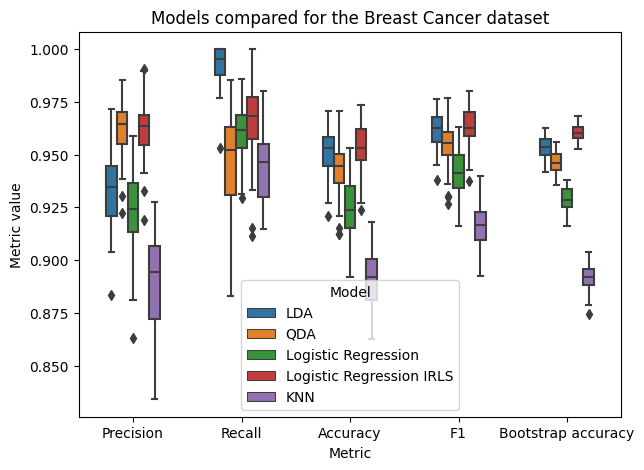

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(data=df, ax=ax, x='metric', y='value', hue='model', width=0.5)

ax.set_title('Models compared for the Breast Cancer dataset')
ax.set_xlabel('Metric')
ax.set_ylabel('Metric value')
ax.set_xticklabels([x.get_text().capitalize() for x in ax.get_xticklabels()])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, title='Model')
plt.show()